# Análisis de datos con Python y Neo4j

In [ ]:
%config IPCompleter.greedy=True

# En primer lugar instalamos el driver de Neo4J para python
!pip install neo4j-driver
# Y pandas para la visualización
!pip install pandas
# Y para las gráficas, matplot
!pip install matplotlib

In [2]:
# Tras esto, importamos nuestro conector y otras librerías
from neo4jConnector import Neo4JConnector
import pandas as pd
import matplotlib.pyplot as plt

## Connector Neo4j

El conector está basado en el driver oficial de Neo4J para **Python**. Esto ha implicado una transformación de las funciones por defecto para poder obtener resultados que sean útiles más tarde para nuestra aplicación.

## Estructura de datos
### Tipos en neo4j.v1

En Neo4j existen dos tipos de entidades sobre las que se basa el sistema de almacenamiento de datos: *nodos* y *relaciones*. Lo que significa que dentro del propio driver se han creado clases específicas para estos elementos.

In [3]:
# Conectamos con la base de datos
h = Neo4JConnector('bolt://localhost:7687','test','4321')

In [4]:
# Se ha mantenido una función inicial customizable para mostrar los datos
records = h.select_custom_original("MATCH (N:INCIDENT)-[R]->(C) RETURN N,R,id(C) LIMIT 1")
print(records)

Como se puede comprobar, el tipo de resultado es un *BoltStatementResult*, que según nuestra query, debería contener tres objetos por cada fila obtenida.

In [5]:
# Iteramos sobre cada fila del objeto record
for element in iter(records):
    for k,v in element.items():
        print(k,'->',v)

N -> <Node id=0 labels={'INCIDENT'} properties={'description': 'WARRANT ARREST', 'incidentNum': 3979}>
R -> <Relationship id=3 start=0 end=3 type='STATUS' properties={}>
id(C) -> 3


Gracias a la función Type, confirmamos la existencia de dos clases específicas para cada tipo de objeto Neo4J. Obtener los datos de cada una de estas estructuras no es trivial, y más cuando se desea utilizar en una aplicación con vistas para el usuario.

Es por ello que se ha desarrollado la función **result_as_list**, la cual devuelve una lista de diccionarios con cada fila obtenida, que distingue a los objetos obtenidos en las llamadas mediante sus **_apodos_**. (Por defecto, *N* para nodos, *R* para relaciones)

Un ejemplo de esto sería la función personalizada **select_limit**: Acepta como máximo dos argumentos, un nombre de etiqueta para el tipo de nodo que se desea recuperar, y el número de filas que debe devolver. El objeto resultado *BoltStatementResult* es parseado y convertido a un formato más simple.

In [6]:
# Un ejemplo de llamada: Queremos 5 nodos de incidentes
record = h.select_limit('INCIDENT',5)

pd.DataFrame([row for row in record])


,N.description,N.incidentNum,N.labels,id
0,WARRANT ARREST,3979,{INCIDENT},0
1,WARRANT ARREST,10128,{INCIDENT},5
2,WARRANT ARREST,10736,{INCIDENT},8
3,WARRANT ARREST,38261,{INCIDENT},11
4,WARRANT ARREST,52205,{INCIDENT},14


### Propiedades en Neo4J

Gracias a esta nueva forma de ordenar los objetos, sabemos que N es un nodo, que lo que procede a 'N.' son sus propiedades (label,description,...) y que todo aquello que no lleve un apodo precediendo no es un elemento **Nodo** o **Relación**.

Para demostrar esto último, se puede utilizar la nueva función personalizada **select_custom**, esta admite una query cypher y devuelve lo especificado en la cláusula *RETURN*.

In [7]:
records = h.select_custom('MATCH (N:INCIDENT)-[R]->(C) RETURN N,R,C LIMIT 2')

pd.DataFrame([row for row in records])

,C.day,C.dayofweek,C.labels,C.month,C.name,C.year,N.description,N.incidentNum,N.labels,R.time,R.type
0,NaN,NaN,{RESOLUTION},NaN,"ARREST, BOOKED",NaN,WARRANT ARREST,3979,{INCIDENT},NaN,STATUS
1,9.0,Thursday,{DATE},12.0,NaN,2004.0,WARRANT ARREST,3979,{INCIDENT},16:22,TIME


A pesar de que en un dataframe la presentación no es aceptable, esto evita un problema, que es la *confusión de elementos*. Se puede ver perfectamente qué elemento es cual, y qué propiedades les pertenecen. Para poder ordenarlos en el futuro, es posible obtener sus **propiedades**.

In [8]:
# Iteramos sobre sus propiedades gracias a los apodos concedidos anteriormente
for i, row in enumerate(records):
    for apodo in ['N','C']:
        props = h.select_node_properties(row[f'{apodo}.labels'].pop())
        print(f'row {i} {apodo}:{props[0]["properties"]}')
    for apodo in ['R']:
        props = h.select_relationship_properties(row[f'{apodo}.type'])
        print(f'row {i} {apodo}:{props[0]["properties"]}')

row 0 N:['incidentNum', 'description']
row 0 C:['name']
row 0 R:[]
row 1 N:['incidentNum', 'description']
row 1 C:['dayofweek', 'day', 'month', 'year']
row 1 R:['time']


## Representación de actividades criminales

Y con estas, iterar sobre los valores anteriores. Por tanto, el potencial de tener acceso a los nombres de las sentencias originales es ilimitado. Podemos comprobar esto con una de las sentencias originales de la parte de procesamiento en la cual se recogen las inidencias por año:

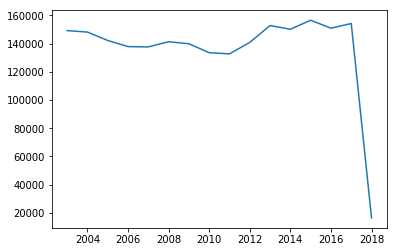

In [9]:
# Iteramos sobre los valores obtenidos...
records = h.select_custom('MATCH (n:INCIDENT)-->(s:DATE) return s.year as Year ,count(n) as Ocurrences ORDER BY Year')

year = list()
ocur = list()

for dic in iter(records):
    year.append(dic['Year'])
    ocur.append(dic['Ocurrences'])
    
plt.plot(year, ocur)
    